# Fraud Detection Case Study for Accerdian

In [2]:
# Importing required models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix,
                             classification_report, precision_recall_curve, roc_curve)
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [3]:
# Load the dataset

data = pd.read_csv("Fraud.csv")

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Checking the shape of the dataset
data.shape

(6362620, 11)

In [5]:
# Checking for the missing values

data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Drop irrelevant features
data = data.drop(['nameOrig', 'nameDest'], axis=1)
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [7]:
data['isFraud'].sum()


np.int64(8213)

In [8]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


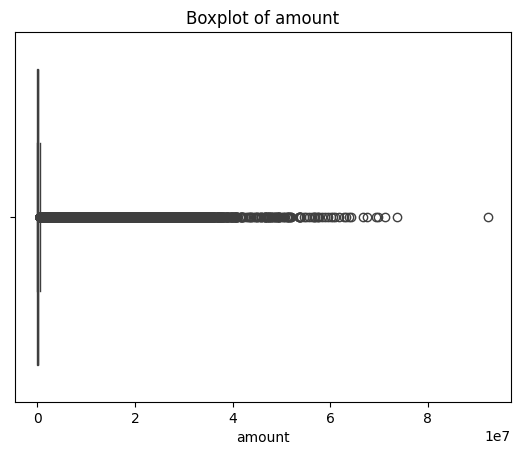

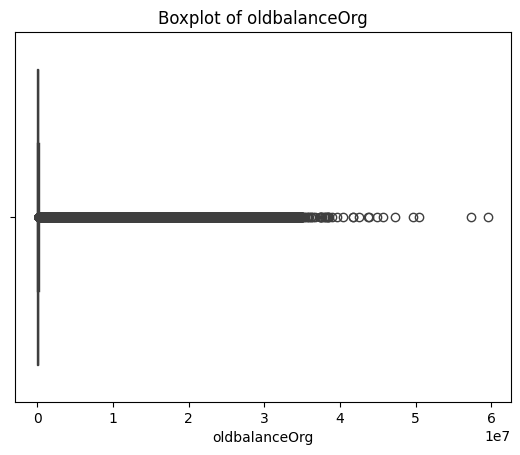

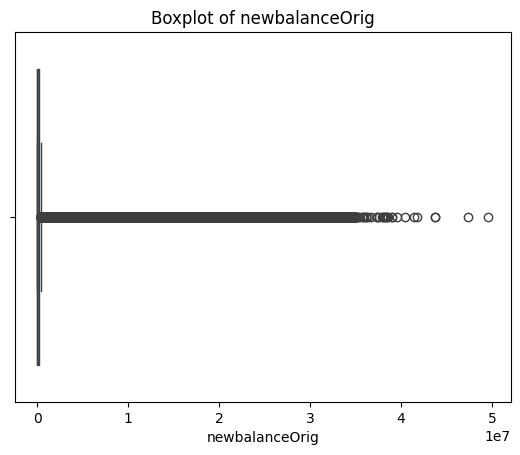

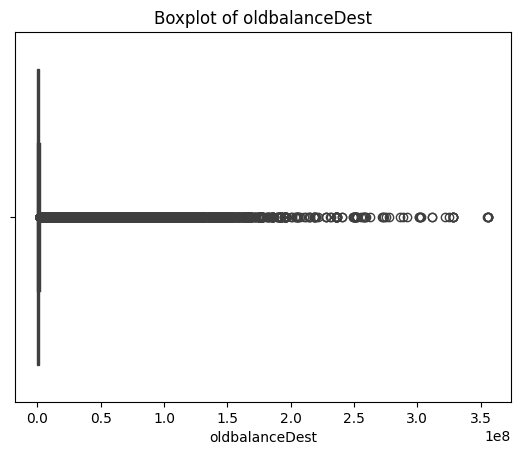

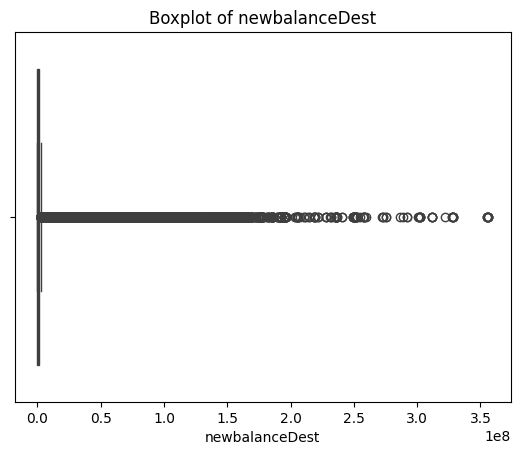

In [9]:
import seaborn as sns

num_cols = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
for col in num_cols:
    plt.figure()
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

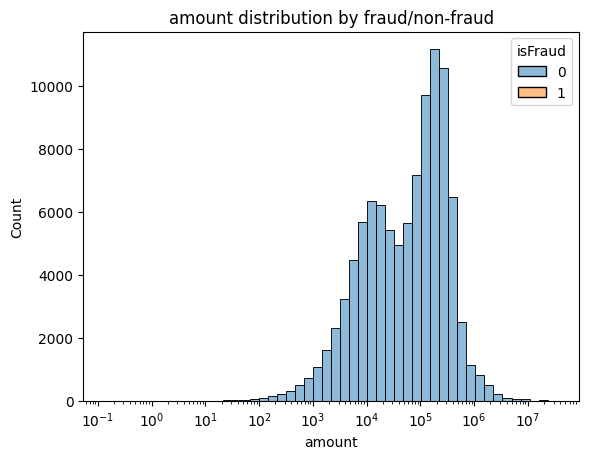

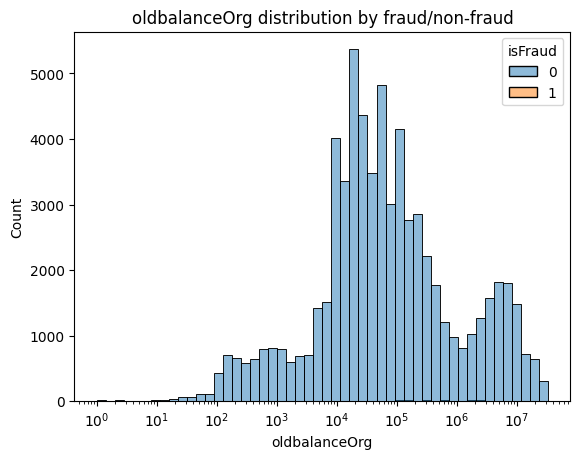

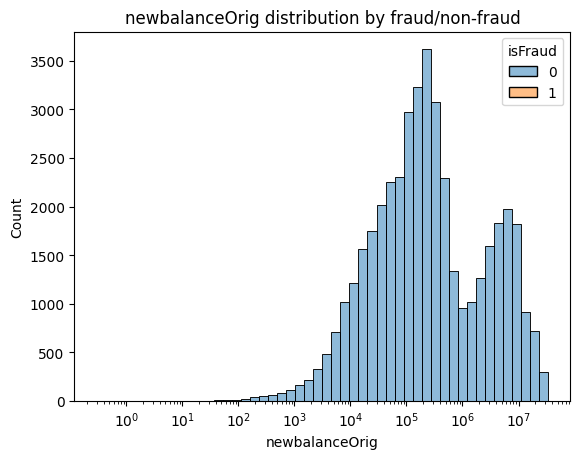

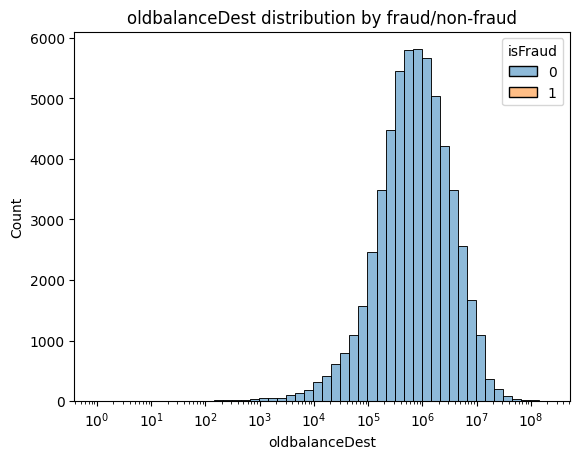

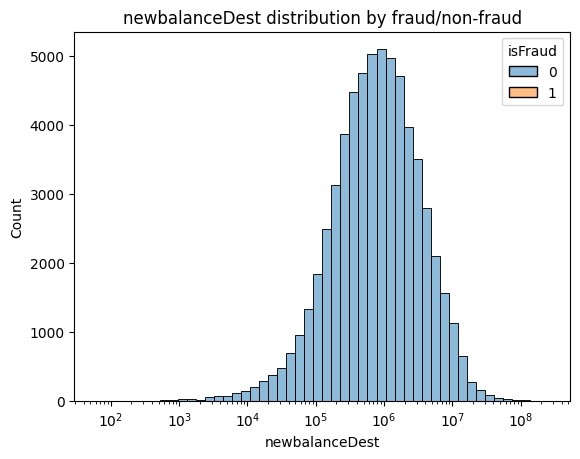

In [10]:
for col in num_cols:
    plt.figure()
    sns.histplot(data=data.sample(100000), x=col, hue="isFraud", log_scale=True, bins=50)
    plt.title(f"{col} distribution by fraud/non-fraud")
    plt.show()

In [11]:
data[num_cols].describe(percentiles=[.01, .05, .95, .99]).T


,count,mean,std,min,1%,5%,50%,95%,99%,max
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,449.4676,2224.0995,74871.940,5.186342e+05,1.615979e+06,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.0000,0.0000,14208.000,5.823702e+06,1.602726e+07,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.0000,0.0000,0.000,5.980262e+06,1.617616e+07,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.0000,0.0000,132705.665,5.147230e+06,1.237182e+07,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.0000,0.0000,214661.440,5.515716e+06,1.313787e+07,3.561793e+08


In [12]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [13]:
Q1 = data["amount"].quantile(0.25)
Q3 = data["amount"].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data["amount"] < Q1 - 1.5*IQR) | (data["amount"] > Q3 + 1.5*IQR)]
print("Outliers in amount:", len(outliers))


Outliers in amount: 338078


In [14]:
# cutoff based on percentiles
lower_cap = data["amount"].quantile(0.01)
upper_cap = data["amount"].quantile(0.99)


In [15]:
# Winsorization
data["amount_capped"] = data["amount"].clip(lower=lower_cap, upper=upper_cap)
data["log_amount"] = np.log1p(data["amount"]) #Compresses extreme highs while keeping order.

In [16]:
data["amount_outlier_flag"] = ((data["amount"] < lower_cap) | (data["amount"] > upper_cap)).astype(int)
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_capped,log_amount,amount_outlier_flag
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,9.839640e+03,9.194276,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1.864280e+03,7.531166,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,4.494676e+02,5.204007,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,4.494676e+02,5.204007,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,1.166814e+04,9.364703,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,3.396821e+05,12.735768,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,1.615979e+06,15.657870,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,1.615979e+06,15.657870,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,8.500025e+05,13.652996,0


# Checking Multicollinearitity

In [17]:
data["errorBalanceOrig"] = data["newbalanceOrig"] + data["amount"] - data["oldbalanceOrg"]
data["errorBalanceDest"] = data["oldbalanceDest"] + data["amount"] - data["newbalanceDest"]


In [18]:
num_cols = ["amount", "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest",
            "errorBalanceOrig", "errorBalanceDest"]


In [19]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = data[num_cols].dropna().sample(20000, random_state=42)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


            Feature           VIF
0            amount  3.049772e+07
1     oldbalanceOrg           inf
2    newbalanceOrig           inf
3    oldbalanceDest           inf
4    newbalanceDest           inf
5  errorBalanceOrig           inf
6  errorBalanceDest           inf


c:\Users\iampa\anaconda3\envs\ann_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [21]:
data_reduced = data.drop(columns=["oldbalanceOrg","newbalanceOrig",
                              "oldbalanceDest","newbalanceDest"])


In [22]:
num_cols_reduced = ["amount","errorBalanceOrig","errorBalanceDest"]
X = data_reduced[num_cols_reduced].dropna().sample(20000, random_state=42)

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


            Feature        VIF
0            amount  16.591452
1  errorBalanceOrig  16.211257
2  errorBalanceDest   1.127217


# EDA & Visualizations

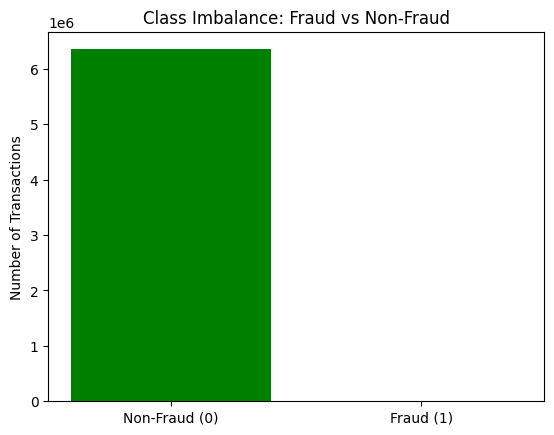

Fraud rate: 0.13%


In [23]:
# Fraud vs Non-fraud counts
counts = data["isFraud"].value_counts().sort_index()
plt.bar(["Non-Fraud (0)", "Fraud (1)"], counts.values, color=["green","red"])
plt.title("Class Imbalance: Fraud vs Non-Fraud")
plt.ylabel("Number of Transactions")
plt.show()

fraud_rate = counts[1] / counts.sum()
print(f"Fraud rate: {fraud_rate:.2%}")

Fraud is ~0.13% of all transactions → extremely rare.

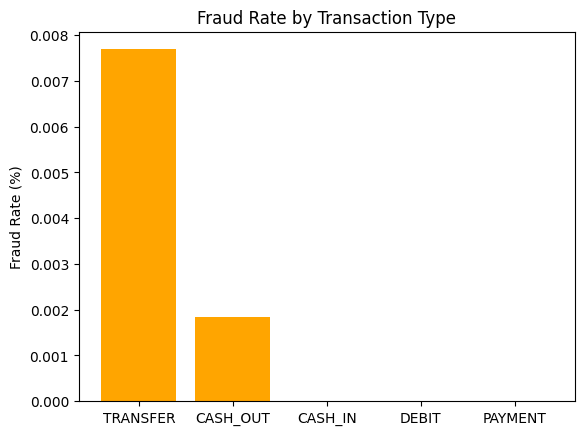

type
TRANSFER    0.768799
CASH_OUT    0.183955
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


In [24]:
# Fraud Rate by Transaction Type
fraud_rate_by_type = data.groupby("type")["isFraud"].mean().sort_values(ascending=False)

plt.bar(fraud_rate_by_type.index, fraud_rate_by_type.values, color="orange")
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate (%)")
plt.show()

print(fraud_rate_by_type * 100)

TRANSFER and CASH_OUT → high fraud rates.   
PAYMENT, CASH_IN, DEBIT → near zero fraud.

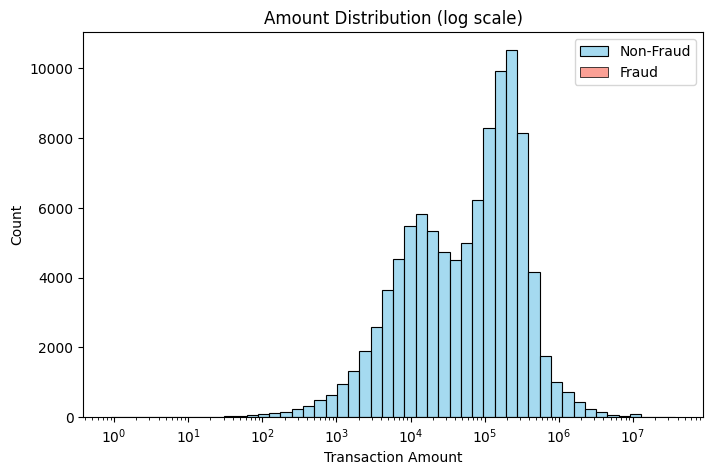

In [25]:
# Amount Distribution (Fraud vs Non-Fraud)
# Take a sample for speed
sample = data.sample(100000, random_state=42)

plt.figure(figsize=(8,5))
sns.histplot(sample[sample["isFraud"]==0]["amount"], bins=50, color="skyblue", label="Non-Fraud", log_scale=True)
sns.histplot(sample[sample["isFraud"]==1]["amount"], bins=50, color="salmon", label="Fraud", log_scale=True)
plt.legend()
plt.title("Amount Distribution (log scale)")
plt.xlabel("Transaction Amount")
plt.show()

Fraud transactions usually involve larger amounts.

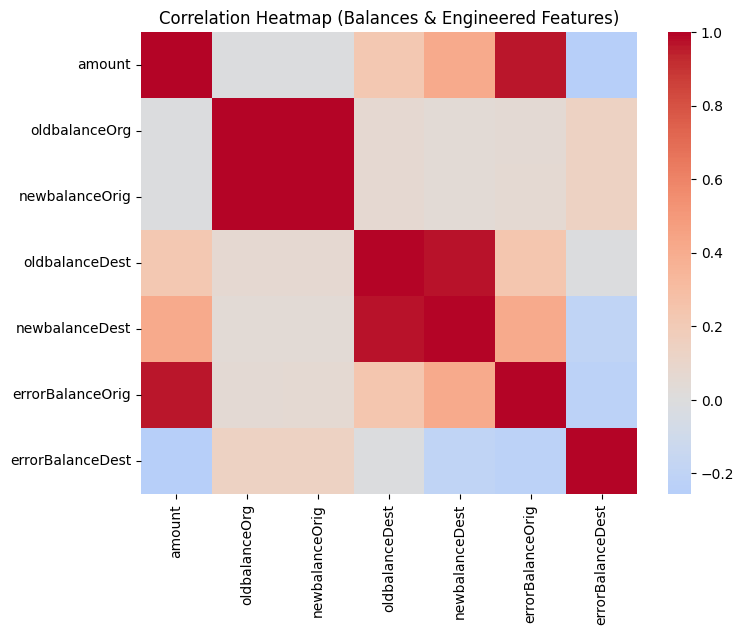

In [26]:
# Correlation Heatmap of Balances 
corr = data[num_cols].sample(50000, random_state=42).corr()  # sample for speed

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Balances & Engineered Features)")
plt.show()

Very strong correlation among raw balances.   
Engineered error features reduce redundancy and show unique fraud patterns.

# Feature Engineering

In [27]:
data = pd.get_dummies(data, columns=["type"], drop_first=True)


In [28]:
# Scaling the features

from sklearn.preprocessing import StandardScaler

num_cols = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest",
            "errorBalanceOrig","errorBalanceDest"]

scaler = StandardScaler()

data[num_cols] = scaler.fit_transform(data[num_cols])

# Model Building

In [36]:
from sklearn.model_selection import train_test_split

# Target variable
y = data["isFraud"]

# Drop columns not needed 
X = data.drop(columns=["isFraud","isFlaggedFraud"])

# Split
# Take 200k samples for model comparison
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=200000, stratify=y_train, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



In [30]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [41]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])),
    "Naive Bayes": GaussianNB()
}

results = []

In [42]:
log_reg = LogisticRegression(max_iter=5000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [43]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, mean_squared_error, mean_absolute_error)

log_reg = LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced")
log_reg.fit(X_sample, y_sample)

y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_log, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_log, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))


c:\Users\iampa\anaconda3\envs\ann_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\iampa\anaconda3\envs\ann_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic Regression
Accuracy: 0.5009367210363026
Precision: 0.0008667869311645099
Recall: 0.33482142857142855
F1 Score: 0.0017290975682600562
ROC-AUC: 0.3331980515222643


In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced", random_state=42)
rf.fit(X_sample, y_sample)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest
Accuracy: 0.9999926654952415
Precision: 1.0
Recall: 0.9943181818181818
F1 Score: 0.9971509971509972
ROC-AUC: 0.9981680410909445


In [45]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    n_estimators=200,
    max_depth=6,
    n_jobs=-1,
    scale_pos_weight=(y_sample.value_counts()[0]/y_sample.value_counts()[1])
)
xgb.fit(X_sample, y_sample)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_xgb, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

c:\Users\iampa\anaconda3\envs\ann_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:38:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
Accuracy: 0.9998187329538251
Precision: 0.8963323353293413
Recall: 0.9719967532467533
F1 Score: 0.932632398753894
ROC-AUC: 0.9974190764054702


In [46]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_sample, y_sample)

y_pred_nb = nb.predict(X_test)
y_proba_nb = nb.predict_proba(X_test)[:,1]

print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_nb, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_nb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_nb))

Naive Bayes
Accuracy: 0.9826444661685491
Precision: 0.022962041070317362
Recall: 0.299512987012987
F1 Score: 0.04265402843601896
ROC-AUC: 0.8164568780111106


In [47]:
# Train Random Forest on the FULL training data
best_rf = RandomForestClassifier(
    n_estimators=200,  
    n_jobs=-1, 
    class_weight="balanced",
    random_state=42
)
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_final = best_rf.predict(X_test)
y_proba_final = best_rf.predict_proba(X_test)[:,1]   # probability of fraud


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final, zero_division=0))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba_final))

KeyboardInterrupt: 

In [49]:
import joblib

# Train the best Random Forest model
final_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced", random_state=42)
final_rf.fit(X_sample, y_sample)


# Save the trained model
joblib.dump(final_rf, "fraud_model.pkl")




['fraud_model.pkl']